## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# Import Google stock data

In [3]:
df = pd.read_csv('google-train.csv',parse_dates=['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927000
2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031900
2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987100
2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876600
2010-01-08,294.894653,300.498657,293.455048,299.885956,299.885956,9483900
...,...,...,...,...,...,...
2018-12-21,1015.299988,1024.020020,973.690002,979.539978,979.539978,4596000
2018-12-24,973.900024,1003.539978,970.109985,976.219971,976.219971,1590300
2018-12-26,989.010010,1040.000000,983.000000,1039.459961,1039.459961,2373300


In [4]:
df=df['Open'].resample('MS').mean()
df

Date
2010-01-01     289.996179
2010-02-01     266.680413
2010-03-01     278.543778
2010-04-01     278.102365
2010-05-01     249.227835
                 ...     
2018-08-01    1226.156950
2018-09-01    1176.878424
2018-10-01    1116.082172
2018-11-01    1054.971424
2018-12-01    1042.156667
Freq: MS, Name: Open, Length: 108, dtype: float64

In [5]:
### Take only 2014-2018
df = df['2015-01-01':]

## Check for stationarity

In [6]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
#adf_test(np.sqrt(np.log(df)))
adf_test(df)

Results of Dickey-Fuller Test:
Test Statistic                 -1.321775
p-value                         0.619152
#Lags Used                      8.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


In [11]:
# Take Log
df_logged = np.log(df)

# Take SQRT
df_sqrt = np.sqrt(df)

# Take difference
#df_diff_one = np.diff(df)

In [12]:
#get movingAvg
movingAvg = df_logged.rolling(window=12).mean()




In [13]:
transformed_df = (df_sqrt - movingAvg).dropna()

In [14]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
#adf_test(np.sqrt(np.log(df)))
adf_test(transformed_df)

Results of Dickey-Fuller Test:
Test Statistic                 -3.586644
p-value                         0.006022
#Lags Used                     10.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


In [15]:
df = transformed_df

C:\Users\gmnya\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


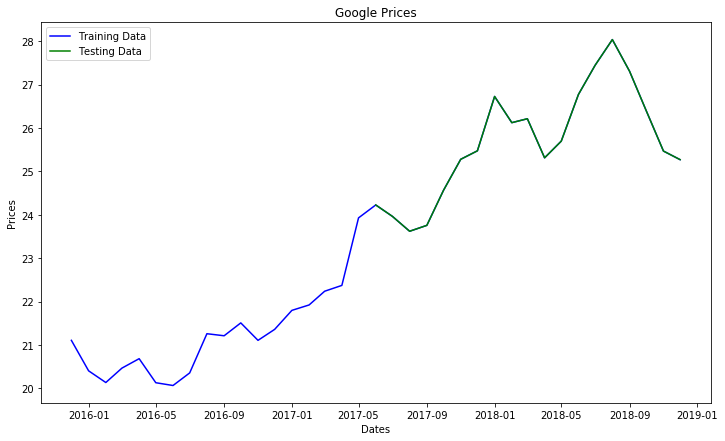

In [16]:
train_data, test_data = df[0:int(len(df)*0.5)], df[int(len(df)*0.5):]
plt.figure(figsize=(12,7))
plt.title('Google Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()

In [17]:
#train_data.shape
test_data.shape

(19,)

In [18]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(df, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

result=stepwise_fit
print(result.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=70.054, BIC=72.410, Fit time=0.059 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=67.323, BIC=72.035, Fit time=0.076 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=68.063, BIC=69.241, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=68.850, BIC=72.384, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIM

In [19]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [20]:
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)



<class 'list'>
Testing Mean Squared Error: 0.455
Symmetric mean absolute percentage error: 5.757


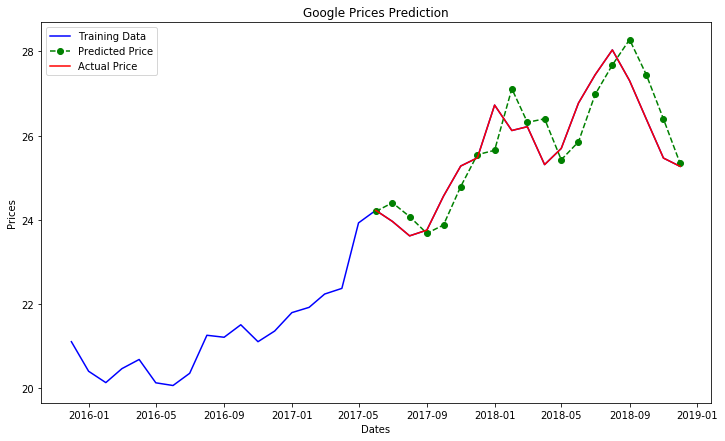

In [21]:
plt.figure(figsize=(12,7))
plt.plot(df, 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data, color='red', label='Actual Price')
plt.title('Google Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()

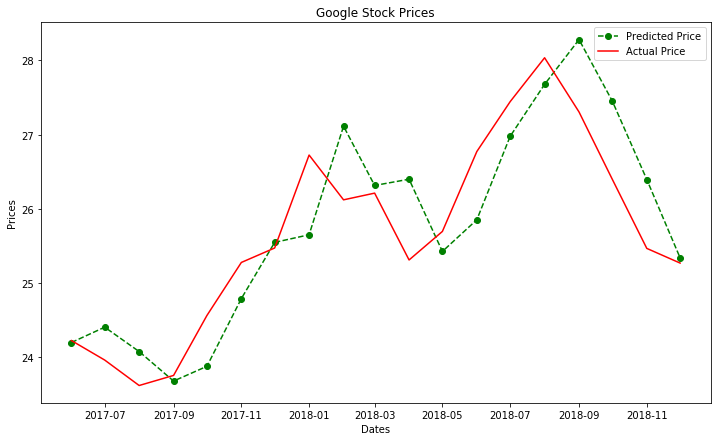

In [22]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_data.index, test_data, color='red', label='Actual Price')
plt.legend()
plt.title('Google Stock Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(6386,7982, 300), df['Date'][6386:7982:300])
plt.legend()

In [23]:
len(predictions)

19

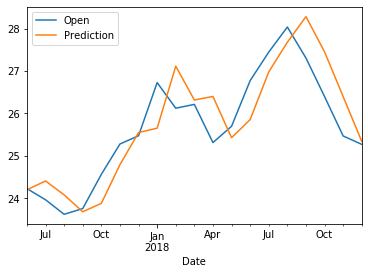

In [24]:
predictions = pd.DataFrame(predictions,index = test_data.index,columns=['Prediction'])
pd.concat([test_data,predictions],axis=1).plot()

In [25]:
predictions.tail()

,Prediction
Date,
2018-08-01,27.677406
2018-09-01,28.280858
2018-10-01,27.450919
2018-11-01,26.395339
2018-12-01,25.339891
